Kira Tahminleme


1.Kütüphaneler

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor

2.Veri Setinin yüklenmesi ve ilk inceleme

In [100]:

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/House_Rent_Dataset.csv')


df = df.drop(columns=['Size'])
df['Floor'] = df['Floor'].str.extract(r'(\d+)').astype(float)
# Eksik değerleri ortalama ile dolduralım (ya da medyan da olur)
df['Floor'] = df['Floor'].fillna(df['Floor'].mean())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [101]:
print(df.head())


    Posted On  BHK   Rent  Floor    Area Type             Area Locality  \
0  2022-05-18    2  10000    2.0   Super Area                    Bandel   
1  2022-05-13    2  20000    1.0   Super Area  Phool Bagan, Kankurgachi   
2  2022-05-16    2  17000    1.0   Super Area   Salt Lake City Sector 2   
3  2022-07-04    2  10000    1.0   Super Area               Dumdum Park   
4  2022-05-09    2   7500    1.0  Carpet Area             South Dum Dum   

      City Furnishing Status  Tenant Preferred  Bathroom Point of Contact  
0  Kolkata       Unfurnished  Bachelors/Family         2    Contact Owner  
1  Kolkata    Semi-Furnished  Bachelors/Family         1    Contact Owner  
2  Kolkata    Semi-Furnished  Bachelors/Family         1    Contact Owner  
3  Kolkata       Unfurnished  Bachelors/Family         1    Contact Owner  
4  Kolkata       Unfurnished         Bachelors         1    Contact Owner  


In [102]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4746 entries, 0 to 4745
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Posted On          4746 non-null   object 
 1   BHK                4746 non-null   int64  
 2   Rent               4746 non-null   int64  
 3   Floor              4746 non-null   float64
 4   Area Type          4746 non-null   object 
 5   Area Locality      4746 non-null   object 
 6   City               4746 non-null   object 
 7   Furnishing Status  4746 non-null   object 
 8   Tenant Preferred   4746 non-null   object 
 9   Bathroom           4746 non-null   int64  
 10  Point of Contact   4746 non-null   object 
dtypes: float64(1), int64(3), object(7)
memory usage: 408.0+ KB
None


In [103]:
# sayısal özet istatistikler
df.describe().T

,count,mean,std,min,25%,50%,75%,max
BHK,4746.0,2.083860,0.832256,1.0,2.0,2.0,3.0,6.0
Rent,4746.0,34993.451327,78106.412937,1200.0,10000.0,16000.0,33000.0,3500000.0
Floor,4746.0,4.025711,5.687893,1.0,1.0,2.0,4.0,76.0
Bathroom,4746.0,1.965866,0.884532,1.0,1.0,2.0,2.0,10.0


In [104]:
#içinde en az 1 eksik değer varsa döndür
df[df.isnull().any(axis=1)]

,Posted On,BHK,Rent,Floor,Area Type,Area Locality,City,Furnishing Status,Tenant Preferred,Bathroom,Point of Contact


In [105]:
print("Eksik değerler:\n", df.isnull().sum())

Eksik değerler:
 Posted On            0
BHK                  0
Rent                 0
Floor                0
Area Type            0
Area Locality        0
City                 0
Furnishing Status    0
Tenant Preferred     0
Bathroom             0
Point of Contact     0
dtype: int64


In [106]:
df['Floor'] = df['Floor'].fillna('No Content')

3.Veri Görselleştirme

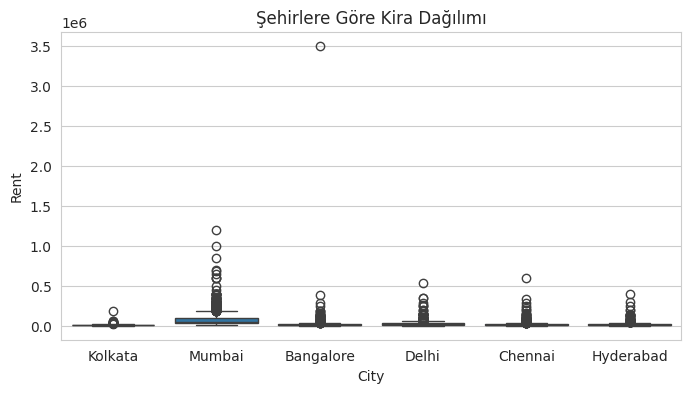

In [107]:
#boxplot
plt.figure(figsize=(8, 4))
sns.boxplot(x='City', y='Rent', data=df)
plt.title('Şehirlere Göre Kira Dağılımı')
plt.show()

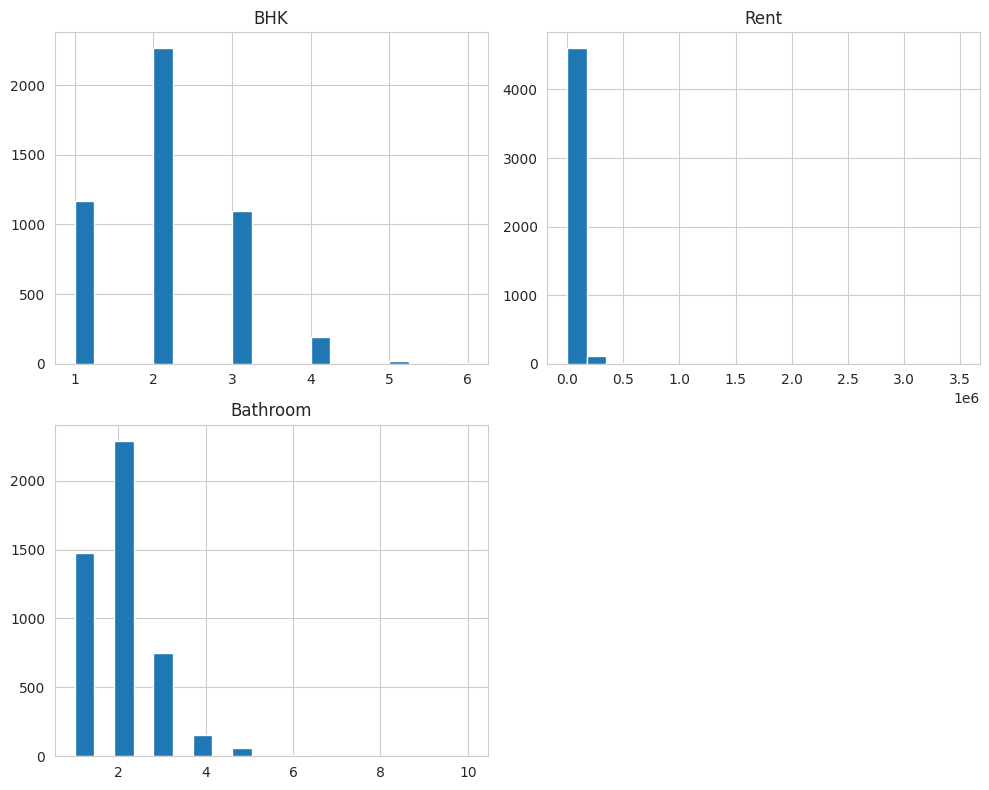

In [108]:
# Histogram
df.select_dtypes(include=['int64','object']).hist(bins=20, figsize=(10,8))
plt.tight_layout()
plt.show()


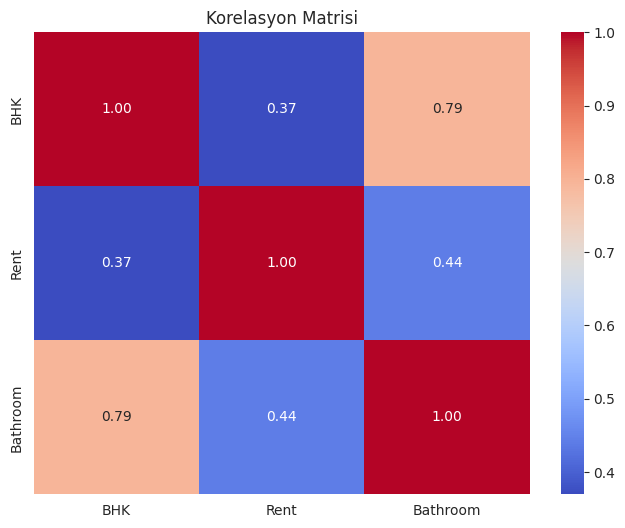

In [109]:
#korelasyon matrisi
numeric_df = df.select_dtypes(include=[ 'int64'])
plt.figure(figsize=(8,6))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Korelasyon Matrisi')
plt.show()

# Özellik önem dereceleri


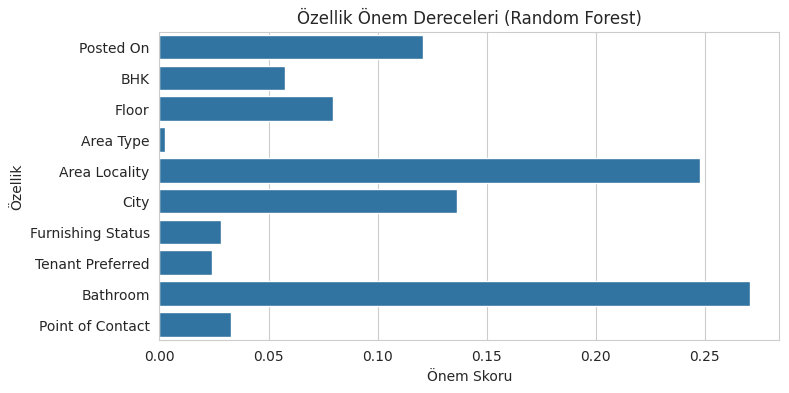

In [110]:
importances = best_rf.feature_importances_
features = X.columns

plt.figure(figsize=(8, 4))
sns.barplot(x=importances, y=features)
plt.title('Özellik Önem Dereceleri (Random Forest)')
plt.xlabel('Önem Skoru')
plt.ylabel('Özellik')
plt.show()

# 4.Kategorik Verileri sayısal hale getirme(LabelEncoder)

In [111]:
le = LabelEncoder()
df['City'] = le.fit_transform(df['City'])
df['Furnishing Status'] = le.fit_transform(df['Furnishing Status'])
df['Tenant Preferred'] = le.fit_transform(df['Tenant Preferred'])
df['Posted On'] = le.fit_transform(df['Posted On'])
df['Area Type'] = le.fit_transform(df['Area Type'])
df['Area Locality'] = le.fit_transform(df['Area Locality'])
df['Point of Contact'] = le.fit_transform(df['Point of Contact'])


# 5. Özellik ve Hedef Değişken

In [112]:
X = df.drop('Rent', axis=1)
y = df['Rent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# 6. Modeller

**Linear Regression


In [113]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
# Performans metrikleri
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
mape_lr = mean_absolute_percentage_error(y_test, y_pred_lr)

print(f"Linear Regression RMSE: {rmse_lr:.2f}")
print(f"Linear Regression MAPE: {mape_lr:.2%}")

Linear Regression RMSE: 48825.72
Linear Regression MAPE: 111.00%


**XGBoost Regressor

In [114]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)


# Performans metrikleri
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mape_xgb = mean_absolute_percentage_error(y_test, y_pred_xgb)

print(f"XGBoost Regressor RMSE: {rmse_xgb:.2f}")
print(f"XGBoost Regressor MAPE: {mape_xgb:.2%}")


XGBoost Regressor RMSE: 56440.64
XGBoost Regressor MAPE: 51.45%


**Random Forest Regressor + GridSearchCV

In [115]:
rf = RandomForestRegressor(random_state=42)
param_grid = {
    'n_estimators': [100, 150],
    'max_depth': [None, 10, 20]
}
gs_rf = GridSearchCV(rf, param_grid, cv=3, scoring='neg_root_mean_squared_error')
gs_rf.fit(X_train, y_train)
best_rf = gs_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

# Performans metrikleri
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape_rf = mean_absolute_percentage_error(y_test, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest MAPE: {mape_rf:.2%}")


Random Forest RMSE: 54616.92
Random Forest MAPE: 43.80%


# 7.Gerçek vs Tahmin Grafiği(Random Forest)

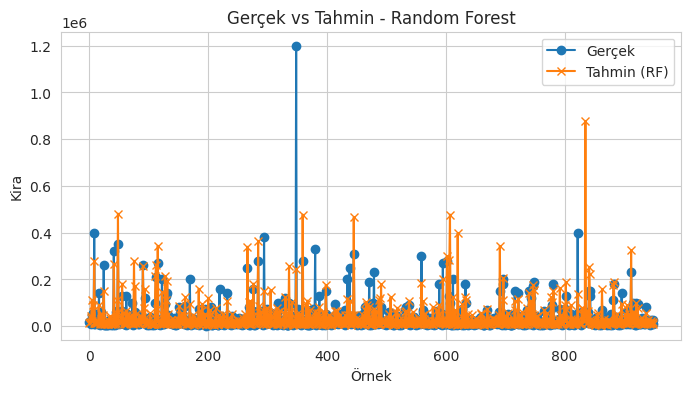

In [116]:
plt.figure(figsize=(8, 4))
plt.plot(y_test.values, label='Gerçek', marker='o')
plt.plot(y_pred_rf, label='Tahmin (RF)', marker='x')
plt.title('Gerçek vs Tahmin - Random Forest')
plt.xlabel('Örnek')
plt.ylabel('Kira')
plt.legend()
plt.show()

#  8 .Modellerin Karşılaştırılması

In [117]:
models = ['Linear Regression', 'XGBoost', 'Random Forest']
predictions = [y_pred_lr, y_pred_xgb, y_pred_rf]

performance_data = []
for name, pred in zip(models, predictions):
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    mape = mean_absolute_percentage_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    performance_data.append([name, rmse, mape, mae, r2])

performance_df = pd.DataFrame(performance_data, columns=['Model', 'RMSE', 'MAPE', 'MAE', 'R²'])
print("\nModel Performans Karşılaştırma Tablosu:")
print(performance_df.sort_values(by='RMSE'))


Model Performans Karşılaştırma Tablosu:
               Model          RMSE      MAPE           MAE        R²
0  Linear Regression  48825.723651  1.109972  22671.085185  0.401826
2      Random Forest  54616.924572  0.437990  16015.816538  0.251512
1            XGBoost  56440.643512  0.514502  17312.042969  0.200692


# 9. Sonuç

<ipython-input-118-f58052cfdf84>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=performance_df, palette='viridis')
<ipython-input-118-f58052cfdf84>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=performance_df, palette='viridis')
<ipython-input-118-f58052cfdf84>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y=metric, data=performance_df, palette='viridis')
<ipython-input-118-f58052cfdf84>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will 

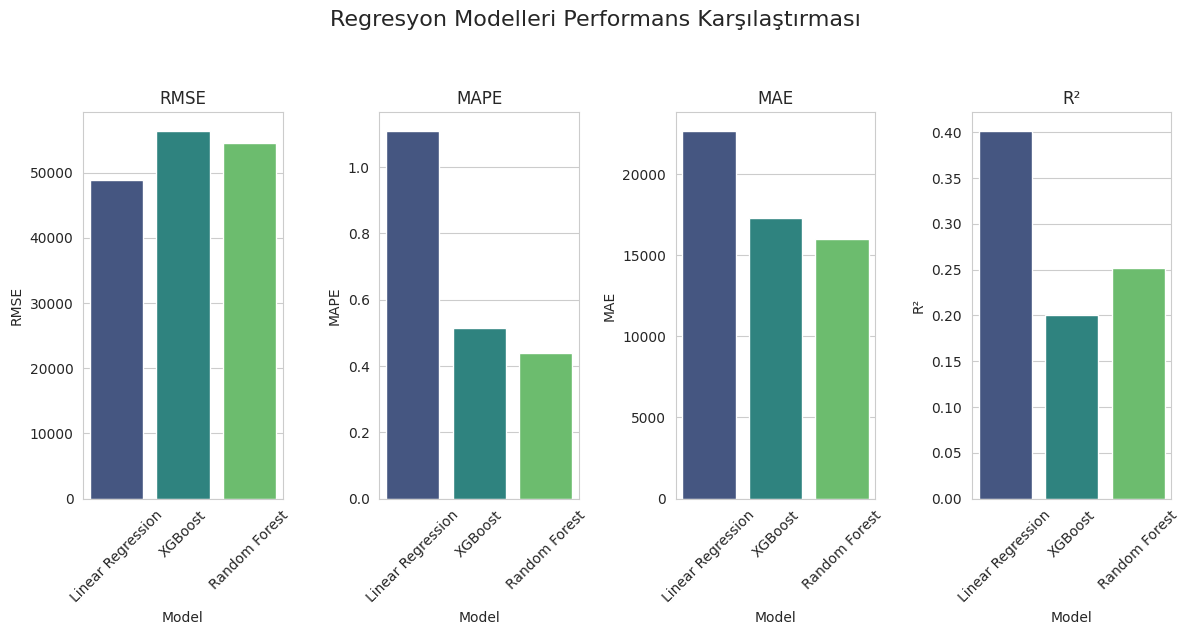

In [118]:

# Grafik ayarları
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Performans metriklerini çiz
metrics = ['RMSE', 'MAPE', 'MAE', 'R²']
for i, metric in enumerate(metrics, 1):
    plt.subplot(1, 4, i)
    sns.barplot(x='Model', y=metric, data=performance_df, palette='viridis')
    plt.xticks(rotation=45)
    plt.title(metric)
    plt.tight_layout()

plt.suptitle("Regresyon Modelleri Performans Karşılaştırması", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()
